## ASHRAE Energy Predictions

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
weather_train = pd.read_csv('weather_train.csv')
weather_test = pd.read_csv('weather_test.csv')
building_metadata = pd.read_csv('building_metadata.csv')

### Analyse des données building

Les données building_meta.csv sont composé de 6 variables définies par :

- site_id : Clé étrangère pour les fichiers météo.
- building_id : Clé étrangère pour training.csv
- primary_use : Indicateur de la catégorie principale d'activités pour le bâtiment basé sur les définitions de type de propriété EnergyStar
- square_feet : Surface de plancher brute du bâtiment
- year_built : Année d'ouverture du bâtiment
- floor_count : Nombre d'étages du bâtiment

In [10]:
#building_metadata = pd.read_csv('building_metadata.csv')

In [11]:
building_metadata.shape

(1449, 6)

In [12]:
building_metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [13]:
building_metadata.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,6.952381,724.000000,92111.776398,1967.957037,3.740845
std,5.003432,418.434583,110769.950997,31.054030,3.333683
min,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.000000,5.000000
max,15.000000,1448.000000,875000.000000,2017.000000,26.000000


In [14]:
building_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int64
building_id    1449 non-null int64
primary_use    1449 non-null object
square_feet    1449 non-null int64
year_built     675 non-null float64
floor_count    355 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


les variables years_built et floor_count ont beaucoup de valeurs manquantes ( 774 pour years_built  et 1094 pour floor_count)

In [15]:
#Define a function to check if there are is any missing information in the datasets
def get_missing_info(df):
    num_entries = df.shape[0]*df.shape[1]
    null_entries = df.isnull().sum().sum()
    percent_empty = null_entries/num_entries*100
    num_missing = df.isna().sum()
    percent_missing = num_missing/len(df)*100
    col_modes = df.mode().loc[0]
    percent_mode = [df[x].isin([df[x].mode()[0]]).sum()/len(df)*100 for x in df]
    missing_value_df = pd.DataFrame({'num_missing': num_missing,
                                     'percent_missing': percent_missing, 
                                     'mode': col_modes,
                                     'percent_mode':percent_mode})
    print('total empty percent:', percent_empty, '%')
    print('columns that are more than 97% mode:', missing_value_df.loc[missing_value_df['percent_mode']>97].index.values)
    return(missing_value_df)

In [16]:
get_missing_info(building_metadata)
# get_missing_info(test)

total empty percent: 21.486082355647575 %
columns that are more than 97% mode: []


,mode,num_missing,percent_missing,percent_mode
site_id,3,0,0.000000,18.909593
building_id,0,0,0.000000,0.069013
primary_use,Education,0,0.000000,37.888199
square_feet,387638,0,0.000000,0.483092
year_built,1976,774,53.416149,3.795721
floor_count,1,1094,75.500345,7.522429


#### Variable primary_use

In [17]:
building_metadata.primary_use.unique()

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

16 types de catégorie principale d'activités pour le bâtiment, la variable primary_use peut être pris comme une varibles catégorielle.


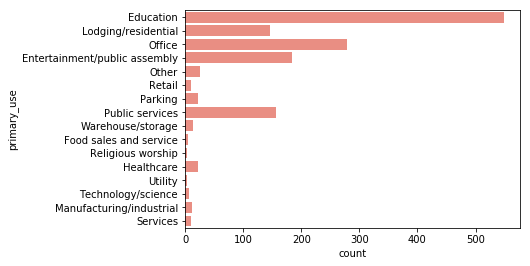

In [18]:
sns.countplot(y="primary_use",data=building_metadata ,color="salmon")

On remarque que la majorité des acitivités des bâtiments est lié à l'éducation, et la minorité est lié a des lieux de culte religieux.  

#### Variable site_id

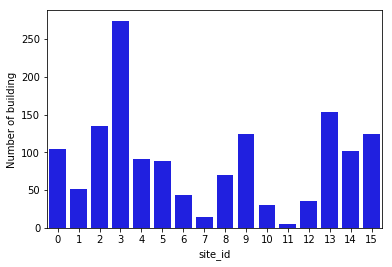

In [19]:
site_build = building_metadata.groupby('site_id').building_id.size()
sns.barplot(x=site_build.index , y= site_build,color="blue")
plt.ylabel("Number of building")
del site_build

On remarque le site 3 a le plus grand nombre de batiments, et le site 11 en a le moins.

#### Variable square_feet, years_built et floor_count

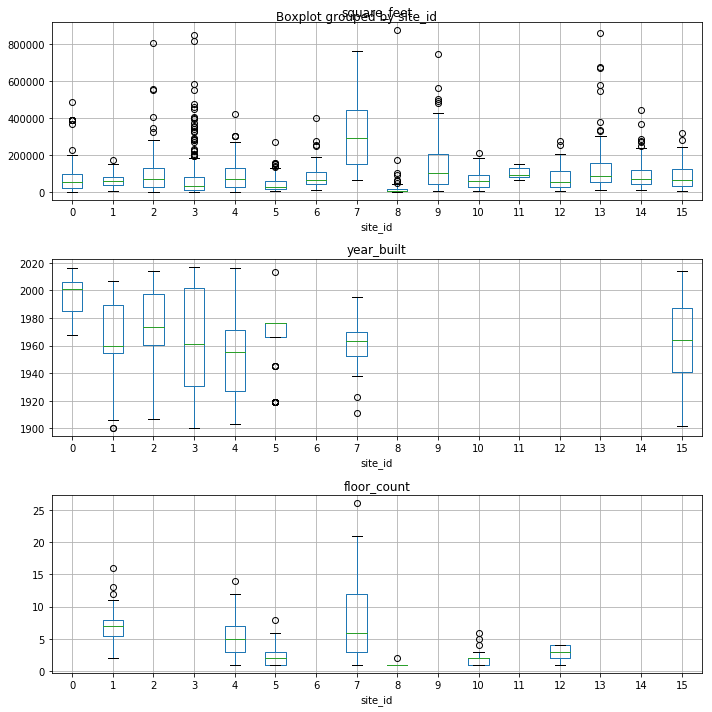

In [21]:
fig, axes = plt.subplots(3,1,figsize=(10,10)) 
columns = building_metadata.drop(["primary_use","site_id","building_id"],axis=1).columns
for i,col in enumerate(list(columns)):
    plot = building_metadata.boxplot(col, by="site_id", ax=axes.flatten()[i])

plt.tight_layout() 

plt.show()

On remarque que le site 0 est un site avec des bâtiments récents, et le site 4 qu'en a lui a des baitments assez anciens. Par rapport au nombres d'étages, le site 8 ne possède pas beaucoup d'étages contrairement au site 7 qui a des bâtiments avec plus d'étages.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115800a58>]],
      dtype=object)

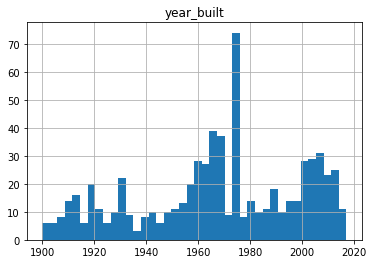

In [22]:
building_metadata.hist(column ="year_built",bins=40)

Beaucoup de batiments datent des années 1975.

In [23]:
building_metadata['year_built'].describe()

count     675.000000
mean     1967.957037
std        31.054030
min      1900.000000
25%      1949.000000
50%      1970.000000
75%      1995.000000
max      2017.000000
Name: year_built, dtype: float64